In [ ]:
!pip install -U sentence-transformers > /dev/null
!pip install git+https://github.com/Bots-Avatar/ExplainitAll > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/Bots-Avatar/ExplainitAll /tmp/pip-req-build-0fa1j76p


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from sentence_transformers import SentenceTransformer, InputExample, CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from torch.utils.data import DataLoader
from explainitall.embedder_interp.embd_interpret import ModelInterp
from explainitall.QA.extractive_qa_sbert.SVDBert import SVDBertModel

In [ ]:
# Инициализация моделей
SENTENCE_TRANSFORMER_SVD = SentenceTransformer('FractalGPT/SbertSVDDistil' )
SENTENCE_TRANSFORMER_SVD[0].auto_model = SVDBertModel.from_pretrained('FractalGPT/SbertSVDDistil')

CROSS_ENCODER_SVD = CrossEncoder('FractalGPT/SbertSVDDistil', num_labels=1 )
CROSS_ENCODER_SVD.model.bert = SVDBertModel.from_pretrained('FractalGPT/SbertSVDDistil')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/44.2M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at FractalGPT/SbertSVDDistil and are newly initialized: ['encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/482k [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at FractalGPT/SbertSVDDistil and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def plot_word_contributions(interpreters, sentence, labels):
    '''Интерпретатор, анализ вклада слова в эмбеддинг'''
    words = sentence.split(' ')
    plt.figure(figsize=(len(words) * 1.5, 4))

    for interp, label in zip(interpreters, labels):
        interp_data = interp.seq_interp(sentence)
        plt.bar(interp_data['words'], interp_data['imp'], alpha=0.7, label=label)

    plt.xlabel("Слова", fontsize=15)
    plt.ylabel("Вклад в эмбеддинг", fontsize=15)
    plt.legend(fontsize=13)
    plt.grid(True)

def calculate_action_probabilities(model, task, environment, actions, temperature=1.0):
    context = f'Задача: {task}. Среда: {environment}'
    action_scores = np.array([model.predict([[context, action]])[0] for action in actions])

    action_scores = np.power(action_scores, 1 / temperature)
    action_probabilities = action_scores / action_scores.sum()

    return dict(zip(actions, action_probabilities))

In [ ]:
ACTION_SCORES = {
        'объехать': {'d': 0.8, 's': 0},
        'тормозить': {'d': 0.6, 's': 0},
        'повернуть влево': {'d': 0.1, 's': 0},
        'повернуть вправо': {'d': 0.1, 's': 0},
        'ехать прямо': {'d': -0.7, 's': 0}
}


DANGER_OBJECTS  = ['кошка', 'собака', 'человек', 'олень', 'кабан', 'медведь', 'колючая проволока']
SAFE_OBJECTS    = ['асфальт', 'дождь', 'разметка', 'дорожное покрытие', 'листик', 'спичечный коробок', 'рисунок']
TASKS           = ['влево', 'вправо', 'прямо']
TYPES_ENV       = ['s', 'd']

In [ ]:
def generate_dataset(action_scores,danger_objects, safe_objects, tasks,types_env, n_samples):
    # Определение влияния действий на оценку

    dataset = []
    for _ in range(n_samples):
        action = random.choice(list(action_scores.keys()))
        task = random.choice(tasks)
        type_env = random.choice(types_env)

        obj = random.choice(danger_objects if type_env == 'd' else safe_objects)
        environment = f'{obj} стоит на дороге'

        # Начальная оценка действия
        score = action_scores[action][type_env]

        # Дополнительная оценка, если задача соответствует действию
        if task in action:
            score += 0.7

        # Нормировка оценки
        score = max(min(score, 1), 0)

        input_text = f'Задача: {task}. Среда: {environment}'
        dataset.append(InputExample(texts=[input_text, action], label=score))

    return dataset

In [ ]:
train_samples = generate_dataset(action_scores = ACTION_SCORES,
                                 danger_objects =DANGER_OBJECTS,
                                 safe_objects = SAFE_OBJECTS,
                                 tasks=TASKS,
                                 types_env=TYPES_ENV,
                                 n_samples=15000)




In [ ]:
num_epochs = 1

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=64)
evaluator = CECorrelationEvaluator.from_input_examples(train_samples, name='sts-dev')
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

CROSS_ENCODER_SVD.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path='/content/model')

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/235 [00:00<?, ?it/s]

In [ ]:
# Симуляция RL
calculate_action_probabilities(model = CROSS_ENCODER_SVD,
                               task = 'прямо', environment='Заяц бежит по дороге',
                               actions=list(ACTION_SCORES.keys()), temperature=0.6)

{'объехать': 0.19634035,
 'тормозить': 0.18129532,
 'повернуть влево': 0.20086509,
 'повернуть вправо': 0.21084139,
 'ехать прямо': 0.2106579}

In [ ]:
# Меняем Bert на обученный на RL
sbert_rl = SentenceTransformer('FractalGPT/SbertSVDDistil')
sbert_rl[0].auto_model = CROSS_ENCODER_SVD.model.bert

Some weights of BertModel were not initialized from the model checkpoint at FractalGPT/SbertSVDDistil and are newly initialized: ['encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


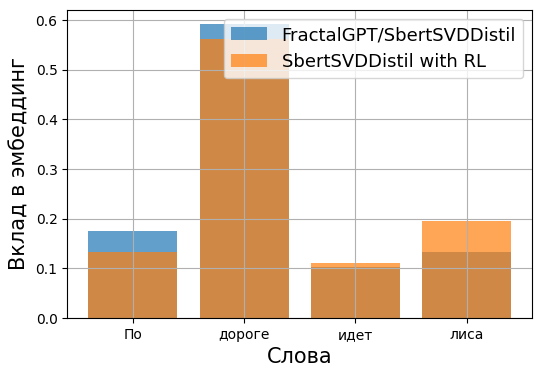

In [ ]:
interp_svd = ModelInterp(SENTENCE_TRANSFORMER_SVD)
interp_svd_rl = ModelInterp(sbert_rl)
plot_word_contributions(interpreters = [interp_svd, interp_svd_rl],
                        sentence= 'По дороге идет лиса',
                         labels = ['FractalGPT/SbertSVDDistil', 'SbertSVDDistil with RL'] )